In [8]:
# import pydicom as dcom #read the dicom files
import os # For directory operation
import pandas as pd # data analysis
import pydicom as dicom

import numpy as np # linear algebra
import scipy.ndimage
import matplotlib.pyplot as plt
import seaborn as sns
p = sns.color_palette()

In [9]:
data_dir="D:FYP/Data Sets/stage1"
patients=os.listdir(data_dir)

patients_labels=pd.read_csv('D:FYP/Data Sets/Labels/stage1_labels.csv',index_col=0)
print("Number of Patients:  ",len(patients))
print("Patient Having Cancer\n",patients_labels.cancer.value_counts())
print("Labels of patients:",patients_labels.head())



Number of Patients:   1595
Patient Having Cancer
 0    1176
1     419
Name: cancer, dtype: int64
Labels of patients:                                   cancer
id                                      
0015ceb851d7251b8f399e39779d1e7d       1
0030a160d58723ff36d73f41b170ec21       0
003f41c78e6acfa92430a057ac0b306e       0
006b96310a37b36cccb2ab48d10b49a3       1
008464bb8521d09a42985dd8add3d0d2       1


In [10]:
print('Number of training patients: {}'.format(len(patients_labels)))
print('Cancer rate: {:.4}%'.format(patients_labels.cancer.mean()*100))

Number of training patients: 1595
Cancer rate: 26.27%


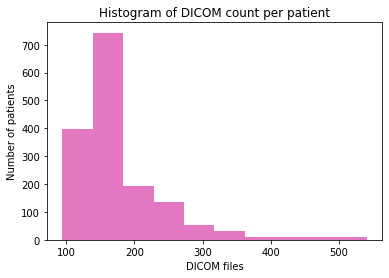

In [18]:
patient_sizes = [len(os.listdir(data_dir+"/" + d)) for d in os.listdir(data_dir)]
plt.hist(patient_sizes, color=p[6])
plt.ylabel('Number of patients')
plt.xlabel('DICOM files')
plt.title('Histogram of DICOM count per patient')
plt.savefig("1.png")

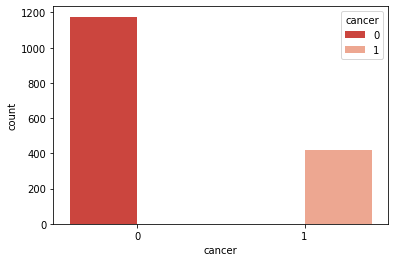

In [22]:
sns_plot=sns.countplot(data=patients_labels,palette="Reds_r", hue="cancer",x='cancer')
fig = sns_plot.get_figure()
fig.savefig("2.png")

In [12]:
# Load the scans in given folder path

# Dicom is the de-facto file standard in medical imaging.
# This is my first time working with it, but it seems to be fairly straight-forward.
# These files contain a lot of metadata (such as the pixel size, 
# so how long one pixel is in every dimension in the real world).

# This pixel size/coarseness of the scan differs from scan to scan (e.g. the distance between slices may differ),
# which can hurt performance of CNN approaches. 
# We can deal with this by isomorphic resampling, which we will do later.

# Below is code to load a scan, which consists of multiple slices,
# which we simply save in a Python list. Every folder in the dataset is one scan (so one patient).
# One metadata field is missing, the pixel size in the Z direction, which is the slice thickness. 
# Fortunately we can infer this, and we add this to the metadata.


def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [13]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

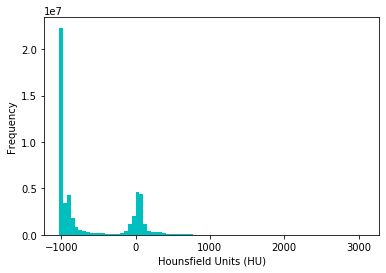

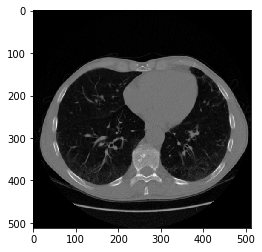

In [32]:
first_patient = load_scan(data_dir+"/" + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()
plt.savefig("6.png")
# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
# plt.show()
plt.savefig("3.png")

In [3]:
for patient in patients[:10]:
    single_label=patients_labels.get_value(patient,"cancer")
    single_patient_dir=data_dir +'/'+ patient

    
    slices = [dicom.read_file(single_patient_dir + '/' + s) for s in os.listdir(single_patient_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(patient,len(slices),single_label,slices[0].pixel_array.shape)

C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


0015ceb851d7251b8f399e39779d1e7d 195 1 (512, 512)
0030a160d58723ff36d73f41b170ec21 265 0 (512, 512)
003f41c78e6acfa92430a057ac0b306e 233 0 (512, 512)
006b96310a37b36cccb2ab48d10b49a3 173 1 (512, 512)
008464bb8521d09a42985dd8add3d0d2 146 1 (512, 512)
0092c13f9e00a3717fdc940641f00015 171 0 (512, 512)
00986bebc45e12038ef0ce3e9962b51a 123 0 (512, 512)
00cba091fa4ad62cc3200a657aeb957e 134 0 (512, 512)
00edff4f51a893d80dae2d42a7f45ad1 135 1 (512, 512)
0121c2845f2b7df060945b072b2515d7 191 0 (512, 512)


# Single dicom_file/patient attributes


In [8]:
print(slices[0])

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.146393066338572104631133125368
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '0121c2845f2b7df060945b072b2515d7'
(0010, 0020) Patient ID                          LO: '0121c2845f2b7df060945b072b2515d7'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.99003790777085209167434407791839316635665824537610224973843
(0020, 000e) Series Instance UID                 UI: 2.25.13362980999203979237682090438492861715422720709248475429620
(0020, 0011) Series Number                       IS: "2"
(0020, 0012) Acquisition Number       

# Pixel Array of a Patient

In [7]:
print(slices[0].pixel_array)

[[  0   0  22 ... 102  87  43]
 [  0  39   7 ... 107  49  27]
 [  0  31  67 ...  53  38  16]
 ...
 [  0  30  79 ...  31  52  63]
 [  0  52  91 ...   4  17  41]
 [  0   0  61 ...   5  24  25]]


# Data Visualization

In [26]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

MAX_IMG_SIZE=150



C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


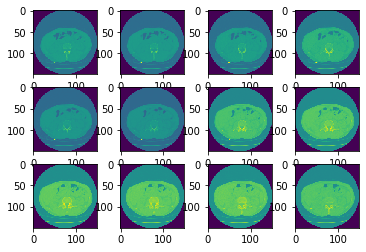

<Figure size 432x288 with 0 Axes>

In [30]:
for patient in patients[:1]:
    single_label=patients_labels.get_value(patient,"cancer")
    single_patient_dir=data_dir +'/'+ patient
    
    slices = [dicom.read_file(single_patient_dir + '/' + s) for s in os.listdir(single_patient_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
#     see multiple slices of a patient
    fig=plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y=fig.add_subplot(3,4,num+1)
        new_image=cv2.resize(np.array(each_slice.pixel_array),(MAX_IMG_SIZE,MAX_IMG_SIZE))
        y.imshow(new_image)
#         y.imshow(new_image,cmap='gray')
plt.show()
plt.savefig("4.png")

# Resized data

C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:13: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


Each Patient Slice:  20 1


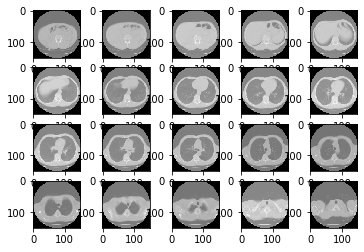

Each Patient Slice:  20 0


<Figure size 432x288 with 0 Axes>

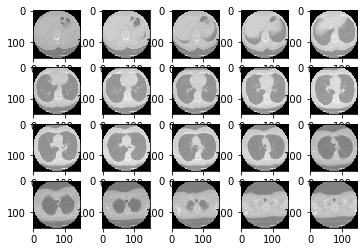

Each Patient Slice:  20 0


<Figure size 432x288 with 0 Axes>

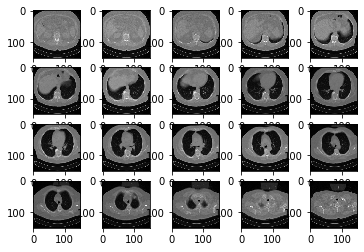

Each Patient Slice:  20 1


<Figure size 432x288 with 0 Axes>

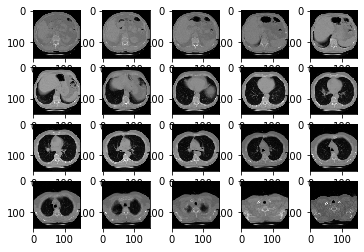

Each Patient Slice:  20 1


<Figure size 432x288 with 0 Axes>

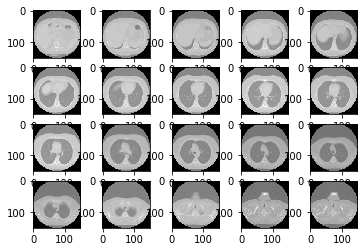

Each Patient Slice:  20 0


<Figure size 432x288 with 0 Axes>

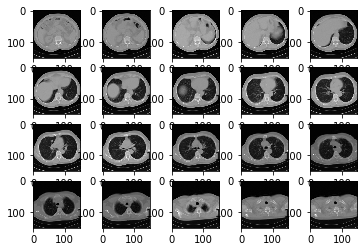

Each Patient Slice:  20 0


<Figure size 432x288 with 0 Axes>

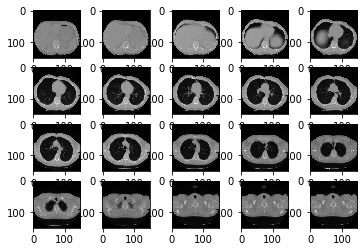

Each Patient Slice:  20 0


<Figure size 432x288 with 0 Axes>

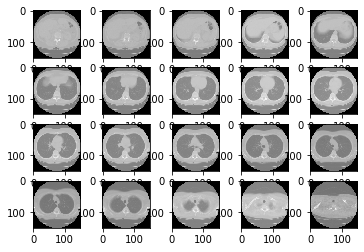

Each Patient Slice:  20 1


<Figure size 432x288 with 0 Axes>

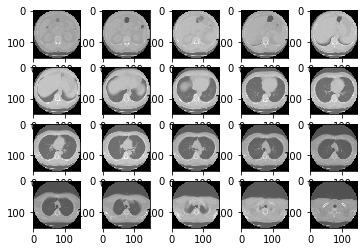

Each Patient Slice:  20 0


<Figure size 432x288 with 0 Axes>

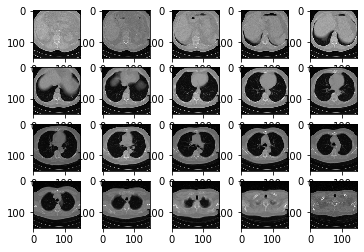

<Figure size 432x288 with 0 Axes>

In [29]:
import math
MAX_SLICES_PER_PATIENT=20

def chunks(l, n):
#     """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def mean(l):
    return sum(l) / len(l)

for patient in patients[:5]:
    single_label=patients_labels.get_value(patient,"cancer")
    single_patient_dir=data_dir +'/'+ patient
    slices = [dicom.read_file(single_patient_dir + '/' + s) for s in os.listdir(single_patient_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    new_slices=[]
    
    slices=[cv2.resize(np.array(each_slice.pixel_array),(MAX_IMG_SIZE,MAX_IMG_SIZE)) for each_slice in slices]
    
    chunk_sizes=math.ceil(len(slices)/MAX_SLICES_PER_PATIENT)
    
    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk=list(map(mean,zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    
    if len(new_slices) == MAX_SLICES_PER_PATIENT-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == MAX_SLICES_PER_PATIENT-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == MAX_SLICES_PER_PATIENT+2:
        new_val = list(map(mean, zip(*[new_slices[MAX_SLICES_PER_PATIENT-1],new_slices[MAX_SLICES_PER_PATIENT],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == MAX_SLICES_PER_PATIENT+1:
        new_val = list(map(mean, zip(*[new_slices[MAX_SLICES_PER_PATIENT-1],new_slices[MAX_SLICES_PER_PATIENT],])))
        del new_slices[MAX_SLICES_PER_PATIENT]
        new_slices[MAX_SLICES_PER_PATIENT-1] = new_val

    print("Each Patient Slice: ",len(new_slices),single_label)

    fig=plt.figure()
    for num,each_slice in enumerate(new_slices):
        y=fig.add_subplot(4,5,num+1)
        y.imshow(each_slice,cmap='gray')
    plt.show()
    plt.savefig("5.png")

# Data Preprocessing


In [23]:
import math
MAX_IMG_SIZE=50
MAX_SLICES_PER_PATIENT=20

def chunks(l, n):
#     """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def mean(l):
    return sum(l) / len(l)

def process_data(index,patient,patients_labels,max_image_size=50,max_slices_per_patient=20,visualize=False):
    single_label=patients_labels.get_value(patient,"cancer")
    single_patient_dir=data_dir +'/'+ patient
    slices = [dicom.read_file(single_patient_dir + '/' + s) for s in os.listdir(single_patient_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    new_slices=[]
    
    slices=[cv2.resize(np.array(each_slice.pixel_array),(MAX_IMG_SIZE,MAX_IMG_SIZE)) for each_slice in slices]
    
    chunk_sizes=math.ceil(len(slices)/MAX_SLICES_PER_PATIENT)
    
    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk=list(map(mean,zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    
    if len(new_slices) == MAX_SLICES_PER_PATIENT-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == MAX_SLICES_PER_PATIENT-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == MAX_SLICES_PER_PATIENT+2:
        new_val = list(map(mean, zip(*[new_slices[MAX_SLICES_PER_PATIENT-1],new_slices[MAX_SLICES_PER_PATIENT],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == MAX_SLICES_PER_PATIENT+1:
        new_val = list(map(mean, zip(*[new_slices[MAX_SLICES_PER_PATIENT-1],new_slices[MAX_SLICES_PER_PATIENT],])))
        del new_slices[MAX_SLICES_PER_PATIENT]
        new_slices[MAX_SLICES_PER_PATIENT-1] = new_val

    print(index,"Each Patient Slice: ",len(new_slices),single_label,single_patient_dir)
    
    if visualize:
        fig=plt.figure()
        for num,each_slice in enumerate(new_slices):
            y=fig.add_subplot(4,5,num+1)
            y.imshow(each_slice,cmap='gray')
        plt.show()
        
    
    if single_label==1:single_label=np.array([0,1])
    elif single_label==0:single_label=np.array([1,0])
    
    return np.array(new_slices),single_label

preprocessed_data=[]
# data_dir="D:FYP/Data Sets/stage1"
# patients=os.listdir(data_dir)
# patients_labels=pd.read_csv('D:FYP/Data Sets/Labels/stage1_labels.csv',index_col=0)

for num,patient in enumerate(patients):
    if(num%100==0):
        print(num)
    try:
        image_data,patient_label=process_data(num+1,patient, patients_labels , max_image_size=MAX_IMG_SIZE , max_slices_per_patient=MAX_IMG_SIZE , visualize=False )
        preprocessed_data.append([image_data,patient_label])
        
    except keyError as e:
        print("This is imlabeled data")
np.save('Preprocessed--{}--{}--{}.npy'.format(MAX_IMG_SIZE,MAX_IMG_SIZE,MAX_SLICES_PER_PATIENT),preprocessed_data)

0


C:\Users\aliza\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


1 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/0015ceb851d7251b8f399e39779d1e7d
2 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/0030a160d58723ff36d73f41b170ec21
3 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/003f41c78e6acfa92430a057ac0b306e
4 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/006b96310a37b36cccb2ab48d10b49a3
5 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/008464bb8521d09a42985dd8add3d0d2
6 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/0092c13f9e00a3717fdc940641f00015
7 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/00986bebc45e12038ef0ce3e9962b51a
8 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/00cba091fa4ad62cc3200a657aeb957e
9 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/00edff4f51a893d80dae2d42a7f45ad1
10 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/0121c2845f2b7df060945b072b2515d7
11 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/013395589c01aa01f8df81d80fb0e2b8
12 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/01de8323fa065a8963533c

98 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/1183f213c1c821df18aad63890920403
99 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/118be21b7e0c3058b29a524686391c66
100 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/11b09ff9de7382d83f79cc81f89f5894
100
101 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/11f10c2a0bfd231deeec98d69e4d0767
102 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/11fe5426ef497bc490b9f1465f1fb25e
103 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/122c5c959fd98036c9972eec2062dc59
104 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/124c4188604434bcdec8358c8ddf9a8b
105 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/124e68a78f9c092a2f16f9214e91268f
106 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/1278988821a696e534c6c93ecdd4ff0c
107 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/12db1ea8336eafaf7f9e3eda2b4e4fef
108 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/12e0e2036f61c8a52ee4471bf813c36a
109 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1

194 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/229b8b785f880f61d8dad636c3dc2687
195 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/2346e52f9370d9dd58172eb44b2b5d87
196 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/234ac5dd589d09a4b2a753ff206d5588
197 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/2365e0afe6844e955f3d4c23a16dc1a9
198 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/23e309ef3a674bcd9c8df40614b93a8e
199 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/24031ba88c58797148475f6d4d5a085b
200 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/243038f7bb7787497c59bc17f04c6ed9
200
201 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/243e69389ae5738d3f89386b0efddbcd
202 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/245fe0c86269602b0dab44c345b0b412
203 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/24626abe1c4544fb39d4e96e33275789
204 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/2488c5b32e837dc848fe6fe4b1bbb7cb
205 Each Patient Slice:  20 0 D:FYP/Data Sets/stag

290 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/3170d41d2bc132db30399fca6bc6f376
291 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/3187b6cf14ed2cbe611b01da5e161f21
292 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/318bf8045b625b40825552420abfe1ef
293 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/31c090cf66ec7bf090801d14d63199b5
294 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/31d037f6e359b56aec064fd3e348adb5
295 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/31e82ed2c875eae8dfbfd70ac440458a
296 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/31f35f920a472a1c3eacb565fe027923
297 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/321364cc2393dccb7ba8894ee9d2b269
298 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/322bf0acacba9650fa5656b9613c75c8
299 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/322d09835e9c6f621262ee68fd3ed596
300 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/323792e42c4f43448b2b1a9651ecb779
300
301 Each Patient Slice:  20 0 D:FYP/Data Sets/stag

386 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/408646e125230c495be91fe171da736e
387 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/40c044145f5c87c12bd8c725924add3c
388 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/40c95c9be0bd7c290534ce374c58bec9
389 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/4131820511c86a5e6b1e7721ab687049
390 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/415ea74bca59eb0ecd5ebb9c2c545f9d
391 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/4165b6e956c0e46e94abf7d98f8d8fe2
392 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/4209cb1fbce28cd68da900eb9bef26b3
393 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/428e25dfddfe731fc73f4e1739422181
394 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/42b2161e43b4dd0ea94604485976c59c
395 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/42bfcfb0e3965039947bd905b2fc3915
396 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/42dbd247a9e5f710926b7c049a00ff48
397 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/4

482 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/51fbac477a3639f983904fc4d42b8c15
483 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/521924ac2f00a62cc63f679de7e599cd
484 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/5253d873ff82e3fa69e30e542d13a4ce
485 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/5267ea7baf6332f29163064aecf6e443
486 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/5275c7ec0f1d80c829611c378708c05b
487 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/5278093ed7187e1a8be518d954509da7
488 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/529e4dd38822b413a4a87e6f4faa5f23
489 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/52f6d741e674f62fbcf73e6ec4f6a472
490 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/53087ef723e2433ad0b8041e408c6f8c
491 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/5368521797323c89292781b8780e45b5
492 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/538543b57d0c8fa0b2b6bb7c84df3f33
493 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/5

578 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/608202eb3c368512e55e9e339a203790
579 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/608a7028689c6ab3aea5f116007169b2
580 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/60a4915d8662dff30dc596ebccb83b3c
581 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/60b1526597b82c98ce96fbe5014c0f2b
582 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/60b389fb2f7eeb912586d1a3ccc9dbbc
583 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/61017c23bbae6e17062ff582d1a237b3
584 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/61406252b7c29fbe372adfa953d95199
585 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/61630ec628631f7fe3980f869e1a4fbe
586 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/616f98dab4db03edbad28c73d22468d2
587 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/6171d57221e26d1f15d3c71fe966ab18
588 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/61917cf6407e793bc0edb60850009e85
589 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/6

674 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/6fd3af9174242c1b393fe4ba515e7a26
675 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/6fd582d25eeb2250c2b0996c4216deb9
676 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/700bdc2723c2ac75a8a8376d9ca170ad
677 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7027c0b8c8f8dcc76c6e4ba923d60a2e
678 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/70287a7720e0d90249ac7b3978b7ca40
679 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7050f8141e92fa42fd9c471a8b2f50ce
680 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7051fc0fcf2344a2967d9a1a5478208e
681 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/70671fa94231eb377e8ac7cba4650dfb
682 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/70f4eb8201e3155cc3e399f0ff09c5ef
683 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/713d8136c360ad0f37d6e53b61a7891b
684 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/71665cc6a7ee85268ca1da69c94bbaeb
685 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7

770 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7daeb8ef7307849c715f7f6f3e2dd88e
771 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7dbc5207b9ec1a1921cc2f03f9b37684
772 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7dc59759253943ac070ab2557c219731
773 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7df28e2253be3490208ba9a9f470ea1d
774 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7eb217c0444e5d866bd462ade5266a06
775 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7ec258e536a1e0353375295ad1b71e5b
776 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7f096cdfbc2fe03ec7f779278416a78c
777 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7f137d30638a87d151ac7e84eeaf48e8
778 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7f45518a2f938a92fa99658d98770316
779 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7f524231183ed193b8f2e3d9cc73c059
780 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/7faa456389e1ffde464819d0b1360188
781 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/7

866 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8c5288b86ffcd597f10d639e9948411d
867 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/8c63c8ebd684911de92509a8a703d567
868 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8c6f2ce60479f73c257173911aff3453
869 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8c7b03ed7f61c7faa5a26e126d769404
870 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8c9925cf3627cd4742bbc8677f905afc
871 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8cb4c49a88d8ecb99d97cf5d707d58d7
872 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8d5c4cc78e964463699c19003be70851
873 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8d98bf96ed8555da4df44f26cc8426bf
874 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8e0624a689e8e02dbae149771f51f8ca
875 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8e60f166f1f1dc0d72f997fe1c9e72b4
876 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8e7638040431e1d91dffa4497f7078d9
877 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/8

962 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/9ce92cb785c9878389bd5f765a07e1ae
963 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/9d44fcc8ab801ac9244da4c016d0541e
964 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/9d453de54a141820fcf62bed9a53540d
965 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/9d89b32f7dea356b2d35cead7bc94d80
966 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/9d8bdc380b51812ba82a6040ef207c33
967 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/9db8f95c3240b79c32af0c0bd367dd91
968 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/9de48cf43611478ffc1fef051b75dc8c
969 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/9de4a1ebcdf1cfd8566ed1d9b63cbeb7
970 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/9e249726076fa41af6766e12957a7e9d
971 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/9e471e15d44721a48d8b5f4b0a160dd6
972 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/9e5c2e760b94b8919691d344cfdbac7f
973 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/9

1057 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/ab9c7bef62d1ad65b824414087b6f06b
1058 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/ab9e5f1718f2af09030dd33b531f066c
1059 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/abc4cfb4ac045b4f9a74e2dbb18f8193
1060 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/abc526fd74d0fdd73772bc6867bc38a4
1061 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/ac00af80df36484660203d5816d697aa
1062 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/ac3345a5a05655c6bcce7d0b226a0042
1063 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/ac366a2168a4d04509693b7e5bcf3cce
1064 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/ac4056071f3cc98489b9db3aebfe2b6a
1065 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/ac4c6d832509d4cee3c7ac93a9227075
1066 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/ac4e4bd5633dd74c99762acdba21934f
1067 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/ac57a379cfea05c07d9befe8b9359495
1068 Each Patient Slice:  20 1 D:FYP/Data S

1152 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/bb94bc5dd4656a2387bafb6098311175
1153 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/bba773fb9c1c517e23efe05e283b58a2
1154 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/bbe21f027a1df4b07016b474b48d3f65
1155 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/bbed0d350caad0e19e5b0fc858097ce4
1156 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/bbf7a3e138f9353414f2d51f0c363561
1157 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/bbf958c2331a553d5699a1369b7f2bbf
1158 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/bc28807c545959c0e6e2708067201caa
1159 Each Patient Slice:  20 1 D:FYP/Data Sets/stage1/bc38f78d1194f57452f6bb5eed453137
1160 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/bc43e8a2cb05a45e73dea8c7e02f2cc1
1161 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/bc848c4d50c2f72fdcc1102475b56525
1162 Each Patient Slice:  20 0 D:FYP/Data Sets/stage1/bca9f24f465ae61a03e35a1f682270bd
1163 Each Patient Slice:  20 0 D:FYP/Data S

NameError: name 'keyError' is not defined

# Neural Network

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
    
much_data = np.load('Preprocessed-50-50-20.npy',allow_pickle=True)
print("Single Iteration.")
print(much_data[0])
print(len(much_data))
train_data = much_data[:100]


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4847933082824524060
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1414607257
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7258177536830187322
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Single Iteration.
[array([[[-2000., -2000., -2000., ..., -2000., -2000., -2000.],
        [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
        [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
        ...,
        [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
        [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
        [-2000., -2000., -2000., ..., -2000., -2000., -2000.]],

       [[-2000., -2000., -2000., ..., -2000., -2000., -2000.],
        [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
        [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
        ...,
        [-2000., -2000.

In [7]:
import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8
def conv3d(x, W):
    #                          one pixel at a time
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about, Same block wwhen edge is reached
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1],  padding='SAME')

def convolutional_neural_network(x):
    #                # 3 x 3 x 3 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       3 x 3 x 3 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output
    
much_data = np.load('Preprocessed-50-50-20.npy',allow_pickle=True)
train_data = much_data[:-100]
validation_data = much_data[-100:]

def train_neural_network(x):
   
    
    prediction = convolutional_neural_network(x)
    print(prediction)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
    saver = tf.train.Saver()
    hm_epochs = 10
    with tf.Session(config=config) as sess:
        sess.run(tf.initialize_all_variables())
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    pass
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    
            
            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]})) 

            writer = tf.summary.FileWriter('./graphs', sess.graph)
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
      
        
        print('fitment percent:',successful_runs/total_runs)
        save_path = saver.save(sess, "model.ckpt")
        print("Model saved in path: %s" % save_path)


train_neural_network(x)

Tensor("add_23:0", shape=(?, 2), dtype=float32)
Epoch 1 completed out of 10 loss: 198426177269.125
Accuracy: 0.58
Epoch 2 completed out of 10 loss: 14691959557.625
Accuracy: 0.68
Epoch 3 completed out of 10 loss: 4590649673.65625
Accuracy: 0.71
Epoch 4 completed out of 10 loss: 2556854063.4375
Accuracy: 0.61
Epoch 5 completed out of 10 loss: 1334214996.9052734
Accuracy: 0.56
Epoch 6 completed out of 10 loss: 309754314.4825205
Accuracy: 0.59
Epoch 7 completed out of 10 loss: 353192227.5523104
Accuracy: 0.53
Epoch 8 completed out of 10 loss: 377483962.9935109
Accuracy: 0.69
Epoch 9 completed out of 10 loss: 157569899.05339128
Accuracy: 0.57
Epoch 10 completed out of 10 loss: 125389462.95802021
Accuracy: 0.61
Done. Finishing accuracy:
Accuracy: 0.62
fitment percent: 0.9993311036789297


UnknownError: Failed to rename: model.ckpt.data-00000-of-00001.tempstate6518128578807708989 to: model.ckpt.data-00000-of-00001 : Access is denied.
; Input/output error
	 [[node save_5/SaveV2 (defined at <ipython-input-7-4c3439864682>:68) ]]

Caused by op 'save_5/SaveV2', defined at:
  File "C:\Users\aliza\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\aliza\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\aliza\Anaconda3\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\aliza\Anaconda3\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\aliza\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-4c3439864682>", line 107, in <module>
    train_neural_network(x)
  File "<ipython-input-7-4c3439864682>", line 68, in train_neural_network
    saver = tf.train.Saver()
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\training\saver.py", line 832, in __init__
    self.build()
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\training\saver.py", line 844, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\training\saver.py", line 881, in _build
    build_save=build_save, build_restore=build_restore)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\training\saver.py", line 510, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\training\saver.py", line 210, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\training\saver.py", line 124, in save_op
    tensors)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1921, in save_v2
    name=name)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

UnknownError (see above for traceback): Failed to rename: model.ckpt.data-00000-of-00001.tempstate6518128578807708989 to: model.ckpt.data-00000-of-00001 : Access is denied.
; Input/output error
	 [[node save_5/SaveV2 (defined at <ipython-input-7-4c3439864682>:68) ]]
